## Exploring Amazon Data: Unlocking Amazon Report Retrieval for Insights and Analysis

In [1]:
import os
import datetime
import time
import glob

import dotenv

import seaborn as sns
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from sp_api.base import Marketplaces,Granularity
from sp_api.api import Orders,Inventories,Products,Reports,Sales
from sp_api.base.reportTypes import ReportType


In [3]:
#%load_ext dotenv
#%dotenv

### All configurations have to be done. View documentation at [Amazon Selling Partner API](https://developer-docs.amazon.com/sp-api/docs/what-is-the-selling-partner-api)


In [2]:
credentials = dict(
        refresh_token=os.environ.get('REFRESH_TOKEN'),
        lwa_app_id=os.environ.get('LWA_APP_ID'),
        lwa_client_secret=os.environ.get('LWA_CLIENT_SECRET'),
        aws_secret_key=os.environ.get('AWS_SECRET_KEY'),
        aws_access_key=os.environ.get('AWS_ACCESS_KEY'),
        role_arn=os.environ.get('ROLE_ARN'))

marketplaceIds = "A1PA6795UKMFR9"

In [3]:
reports = Reports(credentials=credentials,marketplace=Marketplaces.DE)

In [8]:
def fetch_amz_reports(rep, markt_id, test_fetch=False):
    """
    function to fetch reports from Amazon and saves them to the local directory.

    Args:
        rep (str): The report type to fetch.
        markt_id (str): The marketplace ID to fetch the report from.
        test_fetch (bool, optional): Whether to perform a test fetch. Defaults to False.
    """
    data_dir = "../amzdata"
    max_no = 3 if test_fetch else -1

    # Loop through each report type
    for reporttype in list(ReportType)[:max_no]:
        try:
            # Create report
            report = rep.create_report(
                reportType=reporttype,
                dataStartTime="2023-01-01T00:00:00.000Z",
                marketplaceIds=[markt_id],
            )
        except Exception as e:
            print(e)
            
        else:
            # Create a variable to store the report status
            processingStatus = None

            # Loop through the report status for at most 20 times
            for _ in range(20):
                # Get the report status
                status = rep.get_report(report.payload["reportId"])
                # Print the report status
                print(status.processingStatus)
                # If the report is done, cancelled, or failed, set the processingStatus to its status
                if status.processingStatus in ["DONE", "CANCELLED", "FATAL"]:
                    processingStatus = status.processingStatus
                    break
                # Wait 3 seconds between each status update
                time.sleep(3)
            else:
                # If the report takes too long to process, print this message
                print("it take too long time to fetch data")

            # If the report is done, save it to a file
            if processingStatus == "DONE":
                # If the report type is XML, save it as an XML file
                if "XML" in status.reportType:
                    file = str(status.reportType).split("GET_")[1] + ".xml"
                # othwise save it as a CSV file
                else:
                    file = str(status.reportType).split("GET_")[1] + ".csv"

                # Save the report to the local directory
                rep.get_report_document(
                    status.reportDocumentId, download=True, file=os.path.join(data_dir,file)
                )


In [9]:
fetch_amz_reports(reports,marketplaceIds, test_fetch = True)

IN_QUEUE
IN_QUEUE
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
DONE
IN_QUEUE
IN_QUEUE
IN_QUEUE
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
DONE
IN_QUEUE
IN_QUEUE
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
DONE


In [10]:
for reporttype in list(ReportType)[0:5]:
    print(reporttype)

ReportType.GET_V2_SELLER_PERFORMANCE_REPORT
ReportType.GET_FLAT_FILE_OPEN_LISTINGS_DATA
ReportType.GET_MERCHANT_LISTINGS_ALL_DATA
ReportType.GET_MERCHANT_LISTINGS_DATA
ReportType.GET_MERCHANT_LISTINGS_INACTIVE_DATA


In [14]:
# ParserError: Error tokenizing data. C error: Expected 10 fields in line 371, saw 12
colnames= [str(i) for i in range(12)]
amz_bericht = pd.read_csv('../amzdata/Transaktionen fu?r den Zeitr aum 12.1.2023 – 13.1.2023.csv',names=colnames)
amz_bericht.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
241,13.1.2023,Veröffentlicht,Commingling VAT,1410574663,"Tajima Ersatzklingen für Cutter (Breite 18 mm,...",0,0,0,-2.73,-2.73,NaN,NaN
484,12.1.2023,Veröffentlicht,Commingling VAT,1410285403,Tajima Extrastarke Cutterklinge (Ersatzklinge)...,0,0,0,1.43,1.43,NaN,NaN
24,13.1.2023,Veröffentlicht,Bezahlung der Bestellung,306-4282995-5148342,SONAX Aktionsset KratzerEntferner Lack (...,10.46,0,-4.96,1.99,7.49,NaN,NaN
157,13.1.2023,Veröffentlicht,Commingling VAT,1410643613,"Tajima JUMP-SAW Klappsäge (Japansäge, Säge) mi...",0,0,0,-6.11,-6.11,NaN,NaN
479,12.1.2023,Veröffentlicht,Commingling VAT,1410294933,Stehle HW HKS-Massiv Kreissägeblatt für Akku-H...,0,0,0,8.14,8.14,NaN,NaN


In [13]:
def recorrect_columns(df):
    """
    Recorrects the columns of a pandas DataFrame by dropping columns with null values in the 10th column,
    shifting the remaining columns to the left, and converting the data type of the columns from the 6th column
    onwards to numeric.

    Args:
        df (pandas.DataFrame): The DataFrame to be recorrected.

    Returns:
        pandas.DataFrame: The recorrected DataFrame.
    """
    # for each row in the dataframe that has a value in column 10
    for index in df.loc[df["10"].notnull()].index:
        # find the number of columns that should be removed
        col_dif = len(df.columns) - 10
        # set the column number to 5
        column = 5
        # for each column in the dataframe in reverse order
        for i in range(len(df.columns) - 1, 9, -1):
            # set the value of the cell in the current row and column to the value of the cell in the current row and column plus the difference in columns
            if df.iloc[index, i] == "NaN":
                # subtract 1 from the column difference
                col_dif -= 1
        # for each column in the dataframe in reverse order        
        for i in range(len(df.columns) - 1, 4, -1):
            # set the value of the cell in the current row and column to the value of the cell in the current row and column plus the difference in columns
            df.iloc[index, column] = df.iloc[index, column + col_dif]
            # add 1 to the column value
            column += 1
            if column == 10:
                break
        # for each column in the dataframe that is not in the first 5 columns
        for i in range(len(df.columns) - 10):
            # drop the column
            df.drop(str(10 + i), axis=1, inplace=True)
        # set the column names to the values in the first row    
        df.columns = df.iloc[0]
        df = df[1:]
        # for each column in the dataframe that is not in the first 5 columns
        for column in df.columns[5:]:
            # set the value of the column to a numeric data type
            df[column] = pd.to_numeric(df[column])
            
    return df


In [15]:
amz_bericht = recorrect_columns(amz_bericht)

/var/folders/b8/g_kq7hks5k514lxq387j61600000gn/T/ipykernel_52512/3038606196.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column])


In [16]:
def highlight_max(cell):
    
    if type(cell) != str and cell < 0 :
        return 'color: red'
    else:
        return 'color: white'
 

In [17]:
group = amz_bericht.groupby('Transaktionstyp').sum()

/var/folders/b8/g_kq7hks5k514lxq387j61600000gn/T/ipykernel_52512/241308855.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group = amz_bericht.groupby('Transaktionstyp').sum()


In [18]:
 group.style.applymap(highlight_max)

0,Artikelpreise gesamt,Gesamtsumme der Aktionsrabatte,Amazon-Gebühren,Andere,Summe (EUR)
Transaktionstyp,,,,,
Andere,0.000000,0.000000,0.000000,57.390000,57.390000
Bei Amazon gekaufte Versandetiketten,-175.010000,0.000000,0.000000,-11.070000,-186.080000
Bezahlung der Bestellung,9692.420000,-65.250000,-2519.640000,1920.870000,9028.400000
Commingling VAT,0.000000,0.000000,0.000000,-61.610000,-61.610000
Erstattung,-975.870000,1.670000,123.190000,-176.780000,-1027.790000
Nicht verfügbarer Saldo,0.000000,0.000000,0.000000,-713.060000,-713.060000
Nicht verfügbarer Saldo aus vorausgehender Abrechnung,0.000000,0.000000,0.000000,713.060000,713.060000
Service-Gebühren,0.000000,0.000000,0.000000,-28.050000,-28.050000


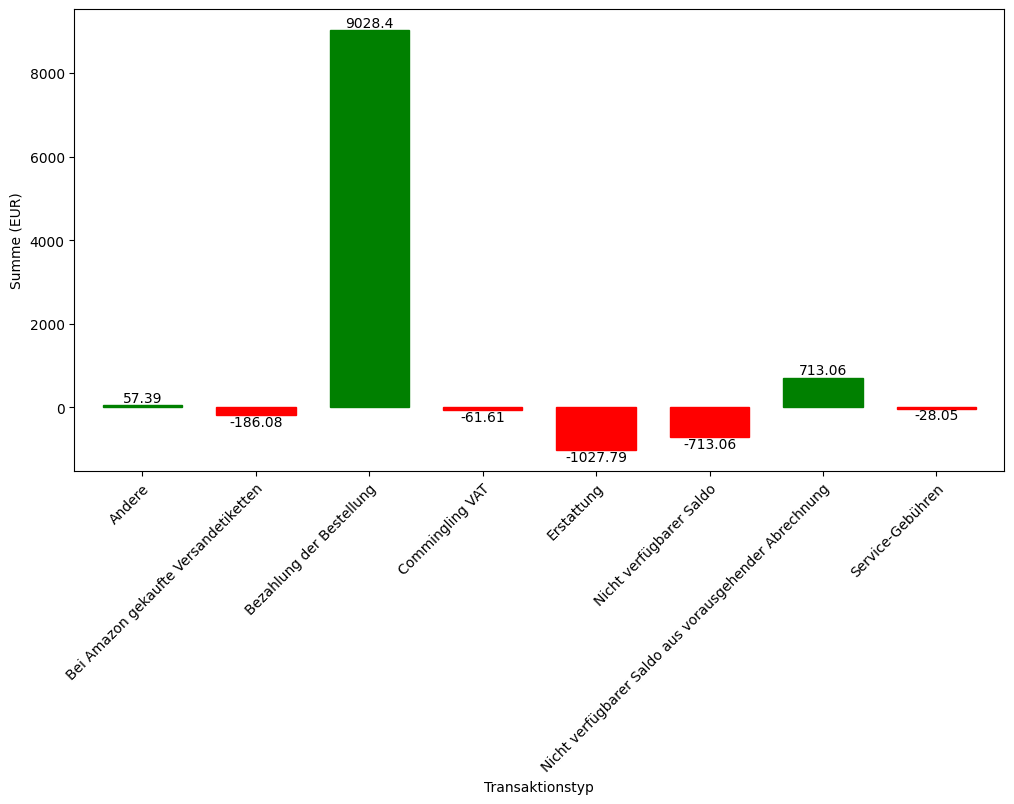

In [19]:
def barplot(group):  
    # plot the bar chart
    ax = group["Summe (EUR)"].plot.bar(figsize=(12, 6), width=0.7)
    # set the y-axis label
    ax.set_ylabel("Summe (EUR)")

    # rotate the x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # loop over the containers
    for container in ax.containers:
        # loop over the bars in the container
        for i in range(len(container.get_children())):
            # check if the bar is positive
            if container.get_children()[i].get_height() >= 0:
                # set the bar color to green
                container.get_children()[i].set_color("green")
            else:
                # set the bar color to red
                container.get_children()[i].set_color("red")

        # add the bar labels to the chart
        ax.bar_label(container)

        
barplot(group)